# Notebook 5 — Diagnostics & Interpretability

Purpose:
- Load the feature-engineered dataset and best hyperparameters from previous notebooks
- Train final models (using selected params) on the training portion and evaluate on the holdout
- Produce per-region/per-month diagnostics, residual analysis, permutation importance, and SHAP summaries (if installed)
- Save diagnostic CSVs and plots to ../4_data_analysis/model_datasets/

Notes:
- This notebook expects the feature-engineered CSV (../4_data_analysis/model_datasets/model_ready_dataset_fe.csv) and best_params.json from Notebook 4.

I added small robustness checks (create Figures output folder, safe SHAP import, safe params handling) but did not rewrite your analysis.

In [20]:
# Imports & paths
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
sns.set()

fe_path = os.path.join('..','4_data_analysis','model_datasets','model_ready_dataset_fe.csv')
params_path = os.path.join('..','4_data_analysis','model_datasets','best_params.json')
out_dir = os.path.join('..','4_data_analysis','model_datasets')
fig_dir = os.path.join('..','4_data_analysis','Figures','model_diagnostics')
os.makedirs(out_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

if not os.path.exists(fe_path):
    raise FileNotFoundError(f'FE dataset not found at {fe_path}. Run Notebook 3/4 first.')
df = pd.read_csv(fe_path)
print('Loaded FE data shape:', df.shape)

best_params = {}
if os.path.exists(params_path):
    try:
        with open(params_path) as f:
            best_params = json.load(f)
    except Exception as e:
        print('Could not load best_params.json:', e)
        best_params = {}
else:
    print('best_params.json not found; falling back to defaults')

print('Loaded best params keys:', list(best_params.keys()))


Loaded FE data shape: (2040, 21)
Loaded best params keys: ['ridge_raw', 'ridge_log1p', 'rf_raw', 'xgb_log1p']


In [21]:
# Ensure Time column and region counts
if 'Time' not in df.columns:
    df = df.sort_values(['REGION','YEAR','Month_Num']).reset_index(drop=True)
    df['Time'] = df.groupby('REGION').cumcount()
print('Per-region counts:')
print(df.groupby('REGION').size())


Per-region counts:
REGION
Central    408
East       408
North      408
South      408
West       408
dtype: int64


In [22]:
# Train/test split: last N months per region (same as Notebook 3)
def train_test_time_split(df, group_col='REGION', time_col='Time', test_periods=30):
    train_parts, test_parts = [], []
    for name, g in df.groupby(group_col):
        g_sorted = g.sort_values(time_col).reset_index(drop=True)
        if len(g_sorted) <= test_periods:
            raise ValueError(f"Region {name} has <= {test_periods} rows; reduce test_periods or drop region")
        train_parts.append(g_sorted.iloc[:-test_periods].copy())
        test_parts.append(g_sorted.iloc[-test_periods:].copy())
    return pd.concat(train_parts).reset_index(drop=True), pd.concat(test_parts).reset_index(drop=True)

train_df, test_df = train_test_time_split(df, test_periods=30)
print('Train shape:', train_df.shape, 'Test shape:', test_df.shape)


Train shape: (1890, 21) Test shape: (150, 21)


Select model + features and target variant to analyze.
- If you used log1p in model selection, pick that path (we will apply inverse transform and clip negatives for diagnostics).
We'll default to RandomForest with saved best params if available, otherwise train a small RF with defaults as a fallback.

In [23]:
target = 'Rainfall'
# build feature list: keep time/month features and engineered lags/rolls
exclude = ['REGION','YEAR','Month','Month_Num','Rainfall','Temperature','Time']
features = [c for c in df.columns if c not in exclude]
features = ['YEAR','Time','Month_sin','Month_cos'] + [c for c in features if ('lag' in c or '_roll' in c)]
features = [c for c in features if c in train_df.columns]
print('Number of features used:', len(features))

# choose params
rf_params = best_params.get('rf_raw') or best_params.get('rf_log1p') or {'n_estimators':200, 'max_depth':10, 'max_features':0.5}
print('RF params used:', rf_params)

# train RF on training set (safe defaults if keys missing)
X_tr = train_df[features]
y_tr = train_df[target]
X_te = test_df[features]
y_te = test_df[target]

rf = RandomForestRegressor(n_jobs=-1, random_state=42, **{k:v for k,v in rf_params.items() if k in ['n_estimators','max_depth','max_features']})
rf.fit(X_tr, y_tr)
pred = rf.predict(X_te)
# Postprocess (clip negatives) — rainfall cannot be negative
pred = np.clip(pred, 0, None)

def metrics(y_true, y_pred):
    return {'rmse': np.sqrt(mean_squared_error(y_true, y_pred)), 'mae': mean_absolute_error(y_true, y_pred), 'r2': r2_score(y_true, y_pred)}

overall = metrics(y_te, pred)
print('Overall test metrics (RF):', overall)


Number of features used: 16
RF params used: {'n_estimators': 200, 'max_depth': 10, 'max_features': 0.5}
Overall test metrics (RF): {'rmse': np.float64(0.9314375147492128), 'mae': 0.5125260357821972, 'r2': 0.8502184987864476}


In [24]:
# Per-region metrics and save
test_df = test_df.copy()
test_df['pred'] = pred

rows = []
for region, g in test_df.groupby('REGION'):
    rows.append({'REGION': region, **metrics(g[target], g['pred']), 'n': len(g)})
per_region_metrics = pd.DataFrame(rows).sort_values('rmse', ascending=True)
per_region_metrics.to_csv(os.path.join(out_dir, 'per_region_metrics.csv'), index=False)
print('Saved per-region metrics to', os.path.join(out_dir, 'per_region_metrics.csv'))
per_region_metrics


Saved per-region metrics to ..\4_data_analysis\model_datasets\per_region_metrics.csv


,REGION,rmse,mae,r2,n
2,North,0.237476,0.130248,0.513024,30
0,Central,0.810029,0.458204,0.738035,30
1,East,0.924110,0.537827,0.253134,30
4,West,1.010368,0.620950,0.867353,30
3,South,1.323070,0.815400,0.845088,30


Residual diagnostics and plots — overall and by region (shows where model fails).

Saved: ..\4_data_analysis\Figures\model_diagnostics\residual_distribution.png


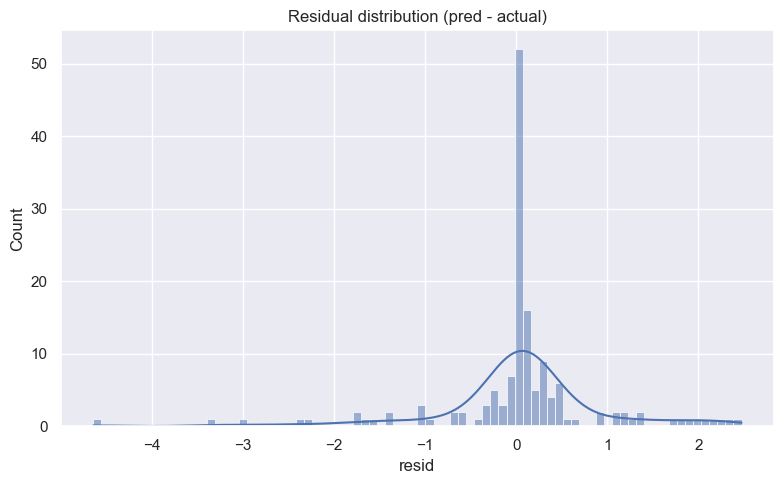

Saved: ..\4_data_analysis\Figures\model_diagnostics\actual_vs_predicted.png


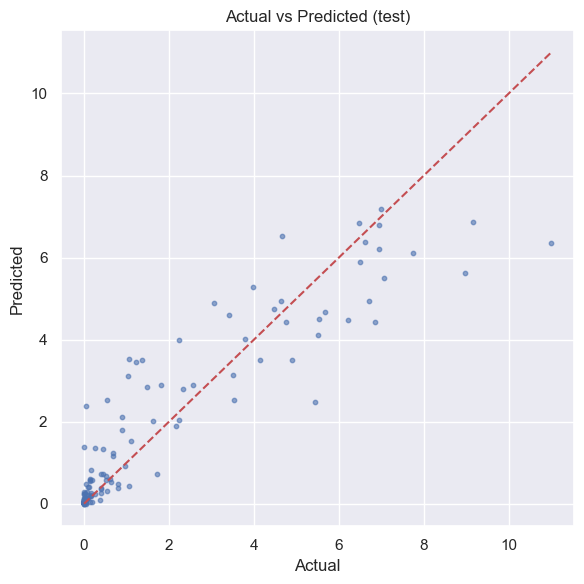

In [25]:
test_df['resid'] = test_df['pred'] - test_df[target]

plt.figure(figsize=(8,5))
sns.histplot(test_df['resid'], bins=80, kde=True)
plt.title('Residual distribution (pred - actual)')
plt.tight_layout()
fn = os.path.join(fig_dir, 'residual_distribution.png')
plt.savefig(fn)
print('Saved:', fn)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(test_df[target], test_df['pred'], alpha=0.6, s=10)
plt.plot([test_df[target].min(), test_df[target].max()], [test_df[target].min(), test_df[target].max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (test)')
plt.tight_layout()
fn = os.path.join(fig_dir, 'actual_vs_predicted.png')
plt.savefig(fn)
print('Saved:', fn)
plt.show()


Permutation importance (global) — a model-agnostic ranking of features using the test set.

In [26]:
perm = permutation_importance(rf, X_te, y_te, n_repeats=10, random_state=42, n_jobs=-1)
imp_df = pd.DataFrame({'feature': X_te.columns, 'importance_mean': perm.importances_mean, 'importance_std': perm.importances_std})
imp_df = imp_df.sort_values('importance_mean', ascending=False)
imp_df.to_csv(os.path.join(out_dir, 'permutation_importance.csv'), index=False)
print('Top features by permutation importance:')
imp_df.head(30)


Top features by permutation importance:


,feature,importance_mean,importance_std
7,Rainfall_lag_12,0.624244,0.069397
4,Rainfall_lag_1,0.087311,0.011198
3,Month_cos,0.039596,0.011537
13,Rainfall_roll12,0.036050,0.007618
12,Rainfall_roll3,0.020456,0.008346
10,Temperature_lag_3,0.007058,0.002429
5,Rainfall_lag_2,0.006864,0.006286
11,Temperature_lag_12,0.005769,0.001873
8,Temperature_lag_1,0.005317,0.001702
9,Temperature_lag_2,0.004989,0.002354


SHAP explanations (if library installed). This can be slow for large datasets — we compute SHAP for a small sample.
If SHAP is not available the cell will print a note and continue.

SHAP installed; computing on sample (may take time)
Saved SHAP summary to ..\4_data_analysis\Figures\model_diagnostics\shap_summary.png


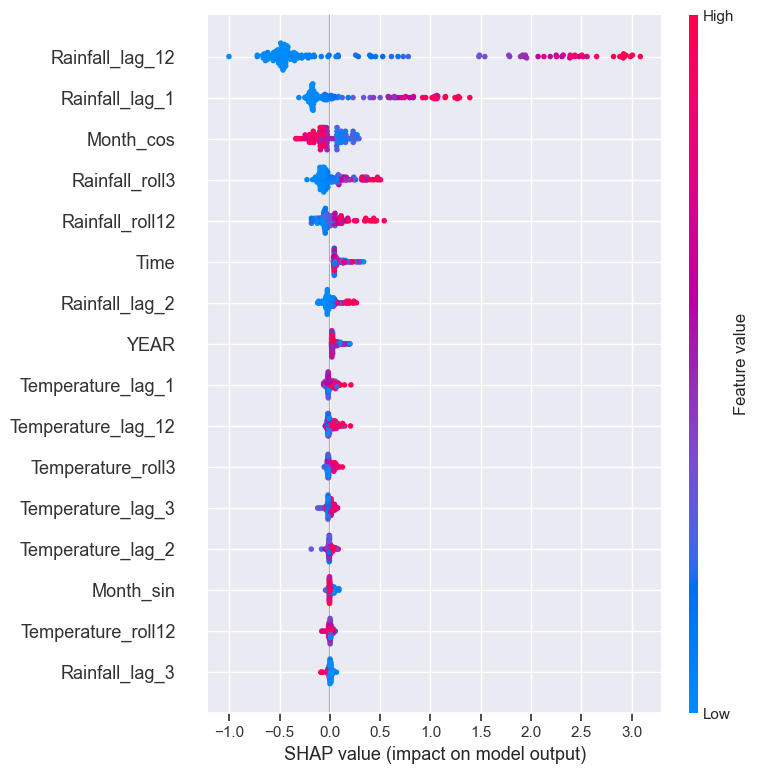

In [27]:
try:
    import shap
    print('SHAP installed; computing on sample (may take time)')
    sample = X_te.sample(min(200, len(X_te)), random_state=42)
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(sample)
    # save summary plot
    plt.figure()
    shap.summary_plot(shap_values, sample, show=False)
    fn = os.path.join(fig_dir, 'shap_summary.png')
    plt.savefig(fn, bbox_inches='tight')
    print('Saved SHAP summary to', fn)
except Exception as e:
    print('SHAP not available or failed; skipping SHAP step. Error:', e)


Next notebook (6) will use the saved model(s) to produce multi-step forecasts and save final outputs for stakeholders."